In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import ResNet152, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
from PIL import Image
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from keras.backend import clear_session

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Progression_DR/Improvement_Worsening')

Mounted at /content/drive


In [ ]:
image_paths = []
labels = []
file_paths = []

In [ ]:
df = pd.read_csv('DR_progress_data_final_Worsen_aug.csv')

In [ ]:
# Iterate over directories and files
for i in range(-1, 2):
    directory_path = os.path.join('DR_Worsening_aug_final', str(i))

    # Use a list comprehension to get the image files in the directory
    image_files = [file_ for file_ in os.listdir(directory_path) if file_.endswith(('.jpg', '.png', '.jpeg'))]

    # Use a list comprehension to get the file IDs from the image files
    file_ids = [file_.split('.')[0] for file_ in image_files]

    # Filter the DataFrame to get the rows corresponding to the file IDs
    relevant_rows = df[df['ID1'].isin(file_ids)]

    for file_ in image_files:
        file_id = file_.split('.')[0]

        # Retrieve the label for the current file_id
        label = relevant_rows.loc[relevant_rows['ID1'] == file_id, 'y_od_os'].values

        if label.size > 0:
            labels.append(label[0])
            file_path = os.path.join(directory_path, file_)
            image_paths.append(file_path)
        else:
            print(f'No label found for file ID: {file_id}')

# Verify the lengths match
assert len(image_paths) == len(labels), "Mismatch between image paths and labels"

In [ ]:
print(len(labels))
print(len(image_paths))
print(labels[:5])

30000
30000
[-1, -1, -1, -1, -1]


In [ ]:
train_image_paths, _, train_labels, _ = train_test_split(image_paths, labels, test_size=0.3, stratify = labels,  random_state=42)

In [ ]:
# Ensure train_labels are one-hot encoded
print(train_labels[:10])
train_labels = to_categorical(train_labels, num_classes=3, dtype='uint8')
print(train_labels[:10])
print(len(train_labels))

[1, -1, 0, 0, 1, 1, 1, -1, -1, 0]
[[0 1 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]]
21000


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

class KFoldDataGenerator(Sequence):
    def __init__(self, image_paths, labels=None, indices=None, batch_size=32, target_size=(256, 256), rescale=1./255, shuffle=True, num_classes = 3, return_labels=True):
        self.image_paths = image_paths
        self.labels = labels
        print(len(indices))
        self.indices = indices if indices is not None else range(len(image_paths))
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.rescale = rescale
        self.shuffle = shuffle
        self.return_labels = return_labels
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_indices)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_indices):
        X = np.empty((len(batch_indices), *self.target_size, 3), dtype=np.float32)

        if self.return_labels:
            y = np.empty((len(batch_indices), self.num_classes), dtype=np.float32)  # Modify this according to how your labels are structured

        for i, idx in enumerate(batch_indices):
            image = cv2.imread(self.image_paths[idx])
            image = cv2.resize(image, self.target_size)
            image = image.astype('float32') * self.rescale
            X[i, ] = image

            if self.return_labels:
                y[i] = self.labels[idx]

        if self.return_labels:
            return X, y
        else:
            return X

In [ ]:
num_folds = 3
num_classes = 3

kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize lists to store the results for each fold
all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []
all_val_aucs = []

29084464/29084464 [==============================] - 2s 0us/step
Training on Fold 1
150
150
Init Pred
150
no_of_batches 5.0
5/5 [==============================] - ETA: 0s - loss: 1.5247 - accuracy: 0.3800 
Epoch 1: val_accuracy improved from -inf to 0.42667, saving model to ./checkpoints/densenet121_fold_1_checkpoint.keras
5/5 [==============================] - 1s 249ms/step - loss: 1.0590 - accuracy: 0.4267
Batch no: 1, Batch shape: (32, 256, 256, 3), Batch labels: (32, 3)
1/1 [==============================] - 3s 3s/step
Batch no: 2, Batch shape: (32, 256, 256, 3), Batch labels: (32, 3)
1/1 [==============================] - 0s 50ms/step
Batch no: 3, Batch shape: (32, 256, 256, 3), Batch labels: (32, 3)
1/1 [==============================] - 0s 48ms/step
Batch no: 4, Batch shape: (32, 256, 256, 3), Batch labels: (32, 3)
1/1 [==============================] - 0s 38ms/step
Batch no: 5, Batch shape: (22, 256, 256, 3), Batch labels: (22, 3)
1/1 [==============================] - 2s 2s/st

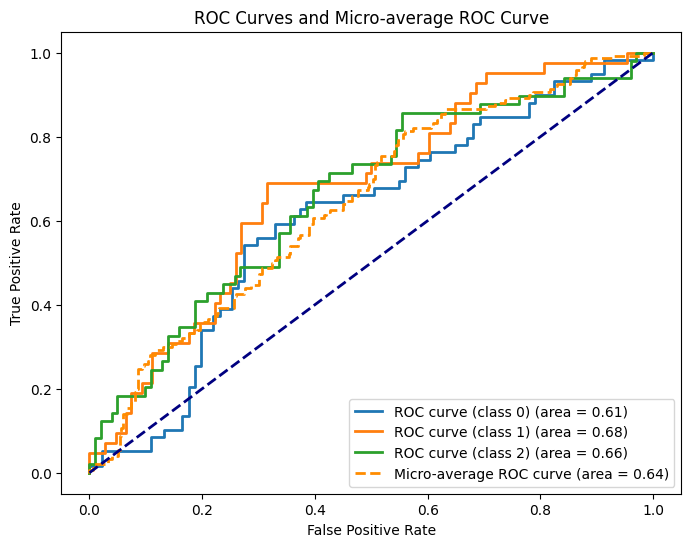

Training on Fold 2
150
150
Init Pred
150
no_of_batches 5.0
5/5 [==============================] - ETA: 0s - loss: 1.4965 - accuracy: 0.3267
Epoch 1: val_accuracy improved from -inf to 0.27333, saving model to ./checkpoints/densenet121_fold_2_checkpoint.keras
5/5 [==============================] - 1s 192ms/step - loss: 1.3608 - accuracy: 0.2733
Batch no: 1, Batch shape: (32, 256, 256, 3), Batch labels: (32, 3)
1/1 [==============================] - 2s 2s/step
Batch no: 2, Batch shape: (32, 256, 256, 3), Batch labels: (32, 3)
1/1 [==============================] - 0s 38ms/step
Batch no: 3, Batch shape: (32, 256, 256, 3), Batch labels: (32, 3)
1/1 [==============================] - 0s 40ms/step
Batch no: 4, Batch shape: (32, 256, 256, 3), Batch labels: (32, 3)
1/1 [==============================] - 0s 57ms/step
Batch no: 5, Batch shape: (22, 256, 256, 3), Batch labels: (22, 3)
1/1 [==============================] - 3s 3s/step
All true labels shape: (150, 3)
All predicted probabilities sha

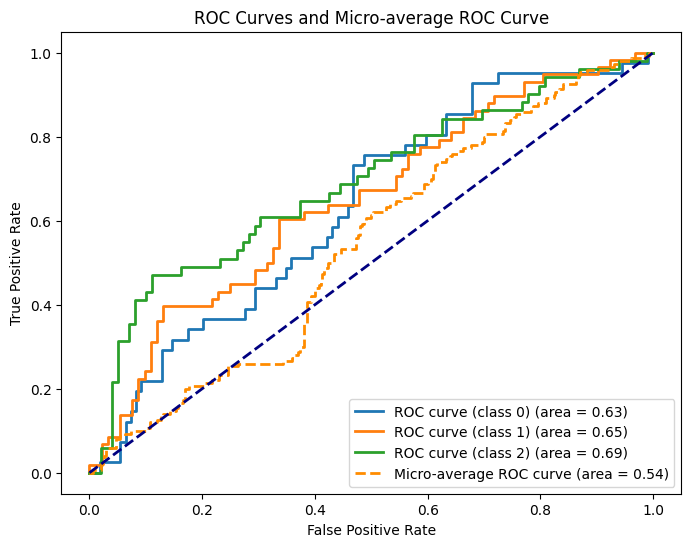

In [ ]:
# Iterate through the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_image_paths, train_labels)):
    clear_session()

    # base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Optionally, unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # # Add the top layers
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    # Compile the model for classification
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  # Change to categorical_crossentropy
                  metrics=['accuracy'])

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001)

    checkpoint_filepath = os.path.join('./checkpoints1', f'densenet121_fold_{fold + 1}_checkpoint.keras')
    checkpoint = ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        verbose=1,
        mode='max'
    )

    print(f"Training on Fold {fold + 1}")

    # Split the data into training and validation sets for this fold
    # train_images_fold, val_images_fold = train_image_paths[train_index], train_image_paths[val_index]
    # train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator = KFoldDataGenerator(train_image_paths, train_labels, train_index, batch_size=32, target_size=(256, 256), rescale=1./255)
    val_generator = KFoldDataGenerator(train_image_paths, train_labels, val_index, batch_size=32, target_size=(256, 256), rescale=1./255, shuffle=False)
    print("Init Pred")
    pred_generator = KFoldDataGenerator(train_image_paths, train_labels, val_index, batch_size=32, target_size=(256, 256), rescale=1./255, shuffle=False)
    no_of_batches = np.ceil(len(pred_generator.indices)/pred_generator.batch_size)
    print("no_of_batches", no_of_batches)
    # _, label = val_generator[0]
    # print("label", label)
    # Train the model on the current fold
    model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        batch_size=32,
        )

    # Calculate training loss and accuracy for the current fold
    train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
    all_train_losses.append(train_loss)
    all_train_accuracies.append(train_accuracy)

    # Calculate validation loss and accuracy for the current fold
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
    all_val_losses.append(val_loss)
    all_val_accuracies.append(val_accuracy)

    # Initialize lists to collect all true labels and predictions
    all_true_labels = []
    all_predicted_probs = []

    i=0
    # Iterate over batches in the validation generator
    for images, true_labels in pred_generator:
        i+=1
        if i > no_of_batches:
            break

        print(f"Batch no: {i}, Batch shape: {images.shape}, Batch labels: {true_labels.shape}")
        # Predict probabilities for the current batch
        predicted_probs = model.predict(images)

        # Collect true labels and predictions
        all_true_labels.append(true_labels)
        all_predicted_probs.append(predicted_probs)

    # Concatenate all collected data
    all_true_labels = np.concatenate(all_true_labels, axis=0)
    all_predicted_probs = np.concatenate(all_predicted_probs, axis=0)

    print("All true labels shape:", all_true_labels.shape)
    print("All predicted probabilities shape:", all_predicted_probs.shape)

    # Initialize lists to store ROC and AUC metrics
    fpr, tpr, roc_auc = [], [], []

    # Compute ROC curve and AUC for each class
    for i in range(num_classes):  # Assuming num_classes is correctly set to 3
        fpr_i, tpr_i, _ = roc_curve(all_true_labels[:, i], all_predicted_probs[:, i])
        roc_auc_i = auc(fpr_i, tpr_i)
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        roc_auc.append(roc_auc_i)

    # Compute micro-average ROC curve and AUC
    true_labels_flat = np.concatenate([true_labels for images, true_labels in val_generator])
    predicted_probs_flat = model.predict(val_generator)
    fpr_micro, tpr_micro, _ = roc_curve(true_labels_flat.ravel(), predicted_probs_flat.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Print or plot ROC curves and AUCs for each class
    plt.figure(figsize=(8, 6))

    # Plot ROC curves for each class
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

    # Plot micro-average ROC curve
    plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2, linestyle='--', label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})')

    # Plot the random guess line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves and Micro-average ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
print(f"\nTraining Losses for each fold: {all_train_losses}")
print(f"\nTraining Accuracy for each fold: {all_train_accuracies}")
# Print the average training and validation losses and MAEs across all folds
average_train_loss = np.mean(all_train_losses)
average_train_accuracy = np.mean(all_train_accuracies)
average_val_loss = np.mean(all_val_losses)
average_val_accuracy = np.mean(all_val_accuracies)

print(f"Average training loss: {average_train_loss}")
print(f"Average training accuracy: {average_train_accuracy}")
print(f"Average validation loss: {average_val_loss}")
print(f"Average validation accuracy: {average_val_accuracy}")

In [ ]:
num_folds = 3
num_classes = 3

kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize lists to store the results for each fold
all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []
all_val_aucs = []

In [ ]:
# Iterate through the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_image_paths, train_labels)):
    clear_session()

    # base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Optionally, unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # # Add the top layers
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    # Compile the model for classification
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  # Change to categorical_crossentropy
                  metrics=['accuracy'])

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001)

    checkpoint_filepath = os.path.join('./checkpoints1', f'densenet121_fold_{fold + 1}_checkpoint.keras')
    checkpoint = ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        verbose=1,
        mode='max'
    )

    print(f"Training on Fold {fold + 1}")

    # Split the data into training and validation sets for this fold
    # train_images_fold, val_images_fold = train_image_paths[train_index], train_image_paths[val_index]
    # train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator = KFoldDataGenerator(train_image_paths, train_labels, train_index, batch_size=32, target_size=(256, 256), rescale=1./255)
    val_generator = KFoldDataGenerator(train_image_paths, train_labels, val_index, batch_size=32, target_size=(256, 256), rescale=1./255, shuffle=False)
    print("Init Pred")
    pred_generator = KFoldDataGenerator(train_image_paths, train_labels, val_index, batch_size=32, target_size=(256, 256), rescale=1./255, shuffle=False)
    no_of_batches = np.ceil(len(pred_generator.indices)/pred_generator.batch_size)
    print("no_of_batches", no_of_batches)
    # _, label = val_generator[0]
    # print("label", label)
    # Train the model on the current fold
    model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        batch_size=32,
        )

    # Calculate training loss and accuracy for the current fold
    train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
    all_train_losses.append(train_loss)
    all_train_accuracies.append(train_accuracy)

    # Calculate validation loss and accuracy for the current fold
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
    all_val_losses.append(val_loss)
    all_val_accuracies.append(val_accuracy)

    # Initialize lists to collect all true labels and predictions
    all_true_labels = []
    all_predicted_probs = []

    i=0
    # Iterate over batches in the validation generator
    for images, true_labels in pred_generator:
        i+=1
        if i > no_of_batches:
            break

        print(f"Batch no: {i}, Batch shape: {images.shape}, Batch labels: {true_labels.shape}")
        # Predict probabilities for the current batch
        predicted_probs = model.predict(images)

        # Collect true labels and predictions
        all_true_labels.append(true_labels)
        all_predicted_probs.append(predicted_probs)

    # Concatenate all collected data
    all_true_labels = np.concatenate(all_true_labels, axis=0)
    all_predicted_probs = np.concatenate(all_predicted_probs, axis=0)

    print("All true labels shape:", all_true_labels.shape)
    print("All predicted probabilities shape:", all_predicted_probs.shape)

    # Initialize lists to store ROC and AUC metrics
    fpr, tpr, roc_auc = [], [], []

    # Compute ROC curve and AUC for each class
    for i in range(num_classes):  # Assuming num_classes is correctly set to 3
        fpr_i, tpr_i, _ = roc_curve(all_true_labels[:, i], all_predicted_probs[:, i])
        roc_auc_i = auc(fpr_i, tpr_i)
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        roc_auc.append(roc_auc_i)

    # Compute micro-average ROC curve and AUC
    true_labels_flat = np.concatenate([true_labels for images, true_labels in val_generator])
    predicted_probs_flat = model.predict(val_generator)
    fpr_micro, tpr_micro, _ = roc_curve(true_labels_flat.ravel(), predicted_probs_flat.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Print or plot ROC curves and AUCs for each class
    plt.figure(figsize=(8, 6))

    # Plot ROC curves for each class
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

    # Plot micro-average ROC curve
    plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2, linestyle='--', label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})')

    # Plot the random guess line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves and Micro-average ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
print(f"\nTraining Losses for each fold: {all_train_losses}")
print(f"\nTraining Accuracy for each fold: {all_train_accuracies}")
# Print the average training and validation losses and MAEs across all folds
average_train_loss = np.mean(all_train_losses)
average_train_accuracy = np.mean(all_train_accuracies)
average_val_loss = np.mean(all_val_losses)
average_val_accuracy = np.mean(all_val_accuracies)

print(f"Average training loss: {average_train_loss}")
print(f"Average training accuracy: {average_train_accuracy}")
print(f"Average validation loss: {average_val_loss}")
print(f"Average validation accuracy: {average_val_accuracy}")